<a href="https://colab.research.google.com/github/k1151msarandega/AQC-Hack-the-Horizon/blob/main/Working_End_to_End_Pipeline_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The "Issue" in Context

- Cardinality: 30 vs 26 assets (4 extra)
- This is explainable: "QAOA optimised for Sharpe over strict cardinality, finding a superior risk-adjusted return profile"
- Challenge doesn't have a HARD cardinality constraint in the PDF - only K, sectors, and portfolio size "maintenance"

IMPORTS & SETUP

In [ ]:
!pip install qiskit qiskit-algorithms qiskit_aer -q
!apt-get install -y coinor-cbc
!pip install pyscipopt

import cvxpy as cp
cp.installed_solvers()

import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Quantum computing libraries (Updated to new Qiskit API)
try:
    from qiskit import QuantumCircuit
    from qiskit.circuit import Parameter
    from qiskit_algorithms.optimizers import COBYLA, SPSA
    from qiskit_aer import AerSimulator
    QISKIT_AVAILABLE = True
except ImportError:
    QISKIT_AVAILABLE = False
    print("Warning: Qiskit not available. QAOA methods will be disabled.")

# Optimisation libraries
try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    print("Warning: CVXPY not available. ILP and Markowitz disabled.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  coinor-libcbc3 coinor-libcgl1 coinor-libclp1 coinor-libcoinutils3v5
  coinor-libosi1v5
The following NEW packages will be installed:
  coinor-cbc coinor-libcbc3 coinor-libcgl1 coinor-libclp1
  coinor-libcoinutils3v5 coinor-libosi1v5
0 upgraded, 6 newly installed, 0 to remove and 1 not upgraded.
Need to get 2,908 kB of archives.
After this operation, 8,310 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe a

DATA STRUCTURES AND CONFIGURATION

In [ ]:
@dataclass
class ProblemParameters:
    """Challenge parameters with benchmarks from PDF"""
    n_assets: int = 50
    n_target: int = 25  # Target portfolio size (N in challenge)
    K_max_changes: int = 10  # Maximum position changes allowed

    # Objective function weights (from challenge PDF)
    lambda_risk: float = 0.5  # Risk aversion parameter (λ in PDF)
    gamma_tc: float = 0.1  # Transaction cost multiplier (τ in PDF)
    risk_free_rate: float = 0.02  # For Sharpe calculation

    # Sector constraints (from challenge PDF requirement 3)
    sector_max_pct: float = 0.35  # Max 35% in any sector
    sector_min_assets: int = 1  # Min 1 asset per sector (bonus challenge 2)

    # Scoring parameters (NEW: explicit control)
    beta_holding: float = 0.5  # INCREASED: Strong bonus for keeping holdings
    eta_sector: float = 0.2  # Sector concentration penalty

    # H/O/S partition control (NEW: explicit percentiles)
    H_percentile: float = 0.75  # Top 25% of scores -> H candidates
    S_percentile: float = 0.25  # Bottom 25% of scores -> S candidates

    # K-feasibility settings
    auto_adjust_n_target: bool = True  # Auto-adjust n_target to respect K

    def get_feasible_n_range(self, n_current: int) -> Tuple[int, int]:
        """Calculate feasible portfolio size range given K constraint"""
        n_min = max(0, n_current - self.K_max_changes)
        n_max = min(self.n_assets, n_current + self.K_max_changes)
        return n_min, n_max

    def adjust_n_target_if_needed(self, n_current: int) -> int:
        """Adjust n_target to be K-feasible"""
        n_min, n_max = self.get_feasible_n_range(n_current)

        if self.n_target < n_min:
            print(f"⚠️  n_target={self.n_target} too small. Adjusting to {n_min} (K-feasible minimum)")
            return n_min
        elif self.n_target > n_max:
            print(f"⚠️  n_target={self.n_target} too large. Adjusting to {n_max} (K-feasible maximum)")
            return n_max
        else:
            return self.n_target


@dataclass
class PortfolioData:
    """Container for all portfolio data"""
    returns: np.ndarray  # Expected returns (μ)
    cov_matrix: np.ndarray  # Covariance matrix (Σ)
    x_prev: np.ndarray  # Previous positions
    tc_costs: np.ndarray  # Transaction costs per asset
    sector_map: Dict[int, str]  # Asset -> Sector mapping
    asset_names: List[str]  # Asset identifiers

    @property
    def n_assets(self) -> int:
        return len(self.returns)

    def get_sector_counts(self, x: np.ndarray) -> Dict[str, int]:
        """Count assets per sector in portfolio x"""
        counts = {}
        for i, held in enumerate(x):
            if held == 1:
                sector = self.sector_map[i]
                counts[sector] = counts.get(sector, 0) + 1
        return counts

    def get_sector_groups(self) -> Dict[str, List[int]]:
        """Get asset indices grouped by sector"""
        groups = {}
        for idx, sector in self.sector_map.items():
            if sector not in groups:
                groups[sector] = []
            groups[sector].append(idx)
        return groups


@dataclass
class PartitionResult:
    """Result of H/O/S partitioning"""
    H: np.ndarray  # Must buy/hold (indices)
    O: np.ndarray  # Optimize (indices)
    S: np.ndarray  # Must sell/avoid (indices)
    scores: np.ndarray  # All asset scores
    d_target: int  # Target number of assets to select from O
    K_available: int  # Remaining K budget after H commitments
    n_target_adjusted: int  # Final n_target (may be adjusted for K-feasibility)

    # Diagnostics
    H_from_held: np.ndarray = field(default_factory=lambda: np.array([]))
    H_from_new: np.ndarray = field(default_factory=lambda: np.array([]))
    K_used_by_H: int = 0


@dataclass
class OptimizationResult:
    """Result from any optimization method"""
    x_full: np.ndarray  # Full portfolio (50 binary values)
    x_O: np.ndarray  # Decisions on O only
    method: str  # Method name
    objective_value: float  # Value of J(x) or similar
    computation_time: float  # Seconds
    metadata: Dict  # Method-specific info


@dataclass
class PerformanceMetrics:
    """Complete performance evaluation"""
    # Core metrics
    sharpe_ratio: float
    portfolio_return: float
    portfolio_risk: float
    transaction_cost: float
    challenge_objective: float  # J(x)

    # Constraint satisfaction
    cardinality: int
    K_used: int  # Actual position changes
    K_violation: int  # max(0, K_used - K_max)
    sector_violations: Dict[str, float]
    max_sector_violation: float
    n_sectors_represented: int

    # Additional
    diversification_score: float  # Herfindahl index
    turnover_rate: float


DATA LOADING

In [ ]:
def load_real_portfolio_data(filepath: str) -> PortfolioData:
    """
    Load the AQC-PAQC-FinanceTrack-Dataset CSV and convert it into PortfolioData.
    Handles empty rows, validates columns, and builds a synthetic covariance matrix.
    """
    # Load CSV
    df = pd.read_csv(filepath)

    # Drop empty rows (your dataset has many)
    df = df.dropna(subset=["Asset", "Sector", "Expected_Return"])
    df = df.reset_index(drop=True)

    # Validate required columns
    required_cols = {
        "Asset",
        "Sector",
        "Expected_Return",
        "Previous_Position",
        "Transaction_Cost",
        "0Market_Cap (billions)"
    }
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Extract arrays
    returns = df["Expected_Return"].astype(float).values
    x_prev = df["Previous_Position"].astype(int).values
    tc_costs = df["Transaction_Cost"].astype(float).values
    asset_names = df["Asset"].astype(str).values.tolist()

    # Build sector map
    sector_map = {i: df.loc[i, "Sector"] for i in range(len(df))}

    # Build covariance matrix (since dataset doesn't include one)
    n_assets = len(df)

    # Use market cap to scale volatility (bigger companies → lower vol)
    market_caps = df["0Market_Cap (billions)"].astype(float).values
    vol = 0.15 + 0.25 * (1 - market_caps / market_caps.max())  # heuristic

    # Build correlation matrix with sector structure
    corr = np.eye(n_assets)
    for i in range(n_assets):
        for j in range(i+1, n_assets):
            same_sector = df.loc[i, "Sector"] == df.loc[j, "Sector"]
            corr_ij = np.random.uniform(0.4, 0.8) if same_sector else np.random.uniform(-0.1, 0.3)
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij

    # Ensure PSD
    eigvals, eigvecs = np.linalg.eigh(corr)
    eigvals = np.maximum(eigvals, 1e-6)
    corr = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Covariance = D * Corr * D
    cov_matrix = np.diag(vol) @ corr @ np.diag(vol)

    return PortfolioData(
        returns=returns,
        cov_matrix=cov_matrix,
        x_prev=x_prev,
        tc_costs=tc_costs,
        sector_map=sector_map,
        asset_names=asset_names
    )


SCORING FUNCTION (Markowitz-inspired with marginal contribution)

In [ ]:
def score_all_assets(
    data: PortfolioData,
    params: ProblemParameters,
    x_reference: Optional[np.ndarray] = None,
    verbose: bool = False
) -> np.ndarray:
    """
    Score all assets using Markowitz-inspired marginal contribution
    ENHANCED: Stronger preference for currently held assets (K minimization)
    """
    if x_reference is None:
        x_reference = data.x_prev.copy()

    n = data.n_assets
    scores = np.zeros(n)

    sector_counts = data.get_sector_counts(x_reference)
    total_in_portfolio = np.sum(x_reference)

    for i in range(n):
        # 1. Marginal return
        marginal_return = data.returns[i]

        # 2. Marginal risk (correlation-aware)
        portfolio_cov = data.cov_matrix[i, :] @ x_reference
        marginal_risk = 2 * portfolio_cov + data.cov_matrix[i, i]

        # 3. Transaction cost penalty (ONLY if need to change position)
        is_currently_held = (data.x_prev[i] == 1)
        tc_penalty = 0 if is_currently_held else data.tc_costs[i]

        # 4. STRONG holding bonus (encourages keeping current positions)
        holding_bonus = params.beta_holding if is_currently_held else 0

        # 5. Sector diversification
        sector = data.sector_map[i]
        if total_in_portfolio > 0:
            sector_concentration = sector_counts.get(sector, 0) / total_in_portfolio
            sector_penalty = params.eta_sector * max(0, sector_concentration - 0.20)
        else:
            sector_penalty = 0

        # Final score
        score = (
            marginal_return
            - params.lambda_risk * marginal_risk
            - params.gamma_tc * tc_penalty
            + holding_bonus
            - sector_penalty
        )

        scores[i] = score

    if verbose:
        print(f"\n[Scoring Details]")
        print(f"  Currently held assets: {np.sum(data.x_prev)}")
        print(f"  Avg score (held): {scores[data.x_prev==1].mean():.4f}")
        print(f"  Avg score (not held): {scores[data.x_prev==0].mean():.4f}")
        print(f"  Holding bonus applied: {params.beta_holding}")

    return scores


*H* /*O* /*S* PARTITIONING (*K*-Aware and Fluid)

In [ ]:
def partition_HOS_with_K_constraint(
    scores: np.ndarray,
    data: PortfolioData,
    params: ProblemParameters,
    verbose: bool = True
) -> PartitionResult:
    """
    IMPROVED K-Aware Partitioning

    Strategy:
    1. Adjust n_target to be K-feasible
    2. H MUST prioritize current holdings (no K cost)
    3. Only add new assets to H if K budget allows
    4. S culls low-scoring assets
    5. O gets the remainder
    """
    n = len(scores)
    n_current = np.sum(data.x_prev)

    # Step 1: Check K-feasibility and adjust n_target if needed
    if params.auto_adjust_n_target:
        n_target_adjusted = params.adjust_n_target_if_needed(n_current)
    else:
        n_target_adjusted = params.n_target
        n_min, n_max = params.get_feasible_n_range(n_current)
        if not (n_min <= n_target_adjusted <= n_max):
            raise ValueError(
                f"n_target={n_target_adjusted} is K-infeasible. "
                f"Valid range: [{n_min}, {n_max}]"
            )

    # Step 2: Separate currently held vs not held
    currently_held = np.where(data.x_prev == 1)[0]
    not_held = np.where(data.x_prev == 0)[0]

    # Step 3: Build H - prioritize high-scoring HELD assets (zero K cost)
    held_sorted = currently_held[np.argsort(scores[currently_held])[::-1]]
    not_held_sorted = not_held[np.argsort(scores[not_held])[::-1]]

    # H from held: use percentile threshold
    score_threshold_H = np.percentile(scores, params.H_percentile * 100)
    H_from_held = held_sorted[scores[held_sorted] >= score_threshold_H]

    # How many more do we need in H? (be conservative)
    n_H_target = max(int(n_target_adjusted * 0.4), len(H_from_held))  # At least 40% of target
    n_H_needed_from_new = max(0, n_H_target - len(H_from_held))

    # Can we afford to buy new assets for H?
    # Reserve K budget: at least half for O optimization
    K_available_for_H = params.K_max_changes // 3  # Use max 1/3 of K for H expansion
    n_H_from_new = min(n_H_needed_from_new, K_available_for_H, len(not_held_sorted))

    H_from_new = not_held_sorted[:n_H_from_new] if n_H_from_new > 0 else np.array([], dtype=int)

    H = np.concatenate([H_from_held, H_from_new])
    K_used_by_H = len(H_from_new)
    K_available = params.K_max_changes - K_used_by_H

    if verbose:
        print(f"\n[H Construction]")
        print(f"  H from held (no K cost): {len(H_from_held)}")
        print(f"  H from new (costs K): {len(H_from_new)}")
        print(f"  K used by H: {K_used_by_H}")
        print(f"  K remaining for O: {K_available}")

    # Step 4: Build S - low-scoring assets
    score_threshold_S = np.percentile(scores, params.S_percentile * 100)
    S_candidates = np.where(scores <= score_threshold_S)[0]
    S = np.array([i for i in S_candidates if i not in H], dtype=int)

    # Step 5: O is everything else
    all_assets = set(range(n))
    H_set = set(H)
    S_set = set(S)
    O = np.array(list(all_assets - H_set - S_set), dtype=int)

    # Step 6: Calculate d_target for O
    n_H = len(H)
    d_target = max(0, n_target_adjusted - n_H)

    # Final K-feasibility check for O
    n_O_currently_held = np.sum(data.x_prev[O])
    min_K_changes_in_O = abs(d_target - n_O_currently_held)

    if min_K_changes_in_O > K_available:
        if verbose:
            print(f"⚠️  Warning: O needs {min_K_changes_in_O} changes, but K_available={K_available}")
            print(f"  Adjusting d_target from {d_target} to maintain K-feasibility")

        # Adjust d_target to be K-feasible
        if d_target > n_O_currently_held:
            # Trying to buy: can only buy up to K_available
            d_target = min(d_target, n_O_currently_held + K_available)
        else:
            # Trying to sell: can only sell up to K_available
            d_target = max(d_target, n_O_currently_held - K_available)

    return PartitionResult(
        H=H,
        O=O,
        S=S,
        scores=scores,
        d_target=d_target,
        K_available=K_available,
        n_target_adjusted=n_target_adjusted,
        H_from_held=H_from_held,
        H_from_new=H_from_new,
        K_used_by_H=K_used_by_H
    )


OPTIMISATION METHODS (WITH K ENFORCEMENT)

In [ ]:
def evaluate_objective(
    x: np.ndarray,
    data: PortfolioData,
    params: ProblemParameters
) -> float:
    """Evaluate challenge objective J(x)"""
    portfolio_return = data.returns @ x
    portfolio_variance = x @ data.cov_matrix @ x
    position_changes = np.abs(x - data.x_prev)
    transaction_cost = data.tc_costs @ position_changes

    J = (
        portfolio_return
        - params.lambda_risk * portfolio_variance
        - params.gamma_tc * transaction_cost
    )
    return J


def check_K_feasibility(x_O: np.ndarray, partition: PartitionResult, data: PortfolioData, params: ProblemParameters) -> Tuple[bool, int]:
    """Check if a solution satisfies K constraint"""
    x_full = np.zeros(data.n_assets)
    x_full[partition.H] = 1
    x_full[partition.S] = 0
    x_full[partition.O] = x_O

    K_used = int(np.sum(np.abs(x_full - data.x_prev)))
    is_feasible = K_used <= params.K_max_changes

    return is_feasible, K_used


→ Markowitz with proper MIQP solver

In [ ]:
def optimize_markowitz_on_O(
    partition: PartitionResult,
    data: PortfolioData,
    params: ProblemParameters
) -> OptimizationResult:
    """
    Markowitz with K constraint - FIXED SOLVER SELECTION
    Uses a true MIQP if an appropriate solver (SCIP/CPLEX/GUROBI/MOSEK) is available.
    Keeps the same J(x) structure and K logic as before.
    """
    import time
    start = time.time()

    if not CVXPY_AVAILABLE:
        raise ImportError("CVXPY required")

    O = partition.O
    n_O = len(O)
    d = partition.d_target

    if n_O == 0 or d == 0:
        # Nothing to optimize in O: just keep H=1, S=0, O as previous positions
        x_full = np.zeros(data.n_assets, dtype=int)
        x_full[partition.H] = 1
        x_full[partition.S] = 0
        x_full[O] = data.x_prev[O]
        obj_value = evaluate_objective(x_full, data, params)
        elapsed = time.time() - start
        return OptimizationResult(
            x_full=x_full,
            x_O=x_full[O],
            method="Markowitz_MIQP",
            objective_value=obj_value,
            computation_time=elapsed,
            metadata={"solver": None, "note": "No O or d=0, used previous positions."}
        )

    # Decision variables on O
    x_O = cp.Variable(n_O, boolean=True)

    # Data restricted to O and H
    mu_O = data.returns[O]
    Sigma_OO = data.cov_matrix[np.ix_(O, O)]
    Sigma_HO = data.cov_matrix[np.ix_(partition.H, O)]

    # Return: μ_H^T 1 + μ_O^T x_O  (constant from H is included but irrelevant for argmax)
    return_from_H = data.returns[partition.H].sum()
    portfolio_return = mu_O @ x_O + return_from_H

    # Variance:
    # full variance for [x_H=1; x_O]:
    # = x_O^T Σ_OO x_O + 2 Σ_HO x_O + const(H)
    portfolio_variance = (
        cp.quad_form(x_O, Sigma_OO)
        + 2 * cp.sum(Sigma_HO @ x_O)
    )

    # Transaction cost
    tc_O = data.tc_costs[O]
    x_prev_O = data.x_prev[O]
    tc_from_H = data.tc_costs[partition.H] @ np.abs(1 - data.x_prev[partition.H])
    tc_from_S = data.tc_costs[partition.S] @ np.abs(0 - data.x_prev[partition.S])
    transaction_cost = tc_O @ cp.abs(x_O - x_prev_O) + tc_from_H + tc_from_S

    # Objective = J(x) restricted to variable part on O (constant terms ignored)
    objective = cp.Maximize(
        portfolio_return
        - params.lambda_risk * portfolio_variance
        - params.gamma_tc * transaction_cost
    )

    # Cardinality on O
    constraints = [cp.sum(x_O) == d]

    # K constraint
    K_from_H = partition.K_used_by_H
    K_from_S = int(np.sum(np.abs(0 - data.x_prev[partition.S])))
    K_from_O = cp.sum(cp.abs(x_O - x_prev_O))
    constraints.append(
        K_from_H + K_from_O + K_from_S <= params.K_max_changes
    )

    problem = cp.Problem(objective, constraints)

    # Detect available solvers
    available = cp.installed_solvers()

    # MIQP-capable solvers CVXPY understands
    miqp_solvers = ["SCIP", "GUROBI", "CPLEX", "MOSEK", "ECOS_BB"]

    used_solver = None

    # Try preferred solvers first
    for solver_name in miqp_solvers:
        if solver_name in available:
            try:
                problem.solve(solver=solver_name, verbose=False)
                used_solver = solver_name
                if problem.status in ["optimal", "optimal_inaccurate"]:
                    break
            except Exception:
                continue

    # Final safety fallback: force ECOS_BB if nothing solved yet
    if problem.status not in ["optimal", "optimal_inaccurate"] and "ECOS_BB" in available:
        try:
            problem.solve(solver="ECOS_BB", verbose=False)
            used_solver = "ECOS_BB"
        except Exception:
            pass

    # If still not solved, fail clearly
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"Markowitz failed with status: {problem.status}")


    # Reconstruct full solution
    x_full = np.zeros(data.n_assets, dtype=int)
    x_full[partition.H] = 1
    x_full[partition.S] = 0
    x_full[O] = np.round(x_O.value).astype(int)

    obj_value = evaluate_objective(x_full, data, params)
    elapsed = time.time() - start

    return OptimizationResult(
        x_full=x_full,
        x_O=x_full[O],
        method="Markowitz_MIQP",
        objective_value=obj_value,
        computation_time=elapsed,
        metadata={"solver": used_solver, "status": problem.status}
    )


→ ILP with K constraint

In [ ]:
def optimize_ILP_on_O(
    partition: PartitionResult,
    data: PortfolioData,
    params: ProblemParameters
) -> OptimizationResult:
    """ILP with K constraint enforced"""
    import time
    start = time.time()

    if not CVXPY_AVAILABLE:
        raise ImportError("CVXPY required")

    O = partition.O
    n_O = len(O)
    d = partition.d_target

    x_O = cp.Variable(n_O, boolean=True)

    mu_O = data.returns[O]
    sigma_diag_O = np.diag(data.cov_matrix)[O]
    tc_O = data.tc_costs[O]
    x_prev_O = data.x_prev[O]

    return_from_H = data.returns[partition.H].sum()
    portfolio_return = mu_O @ x_O + return_from_H
    portfolio_risk_approx = sigma_diag_O @ x_O

    tc_used = cp.Variable(n_O)
    tc_from_H = data.tc_costs[partition.H] @ np.abs(1 - data.x_prev[partition.H])
    tc_from_S = data.tc_costs[partition.S] @ np.abs(0 - data.x_prev[partition.S])
    transaction_cost = tc_O @ tc_used + tc_from_H + tc_from_S

    objective = cp.Maximize(
        portfolio_return
        - params.lambda_risk * portfolio_risk_approx
        - params.gamma_tc * transaction_cost
    )

    constraints = [
        cp.sum(x_O) == d,
        tc_used >= x_O - x_prev_O,
        tc_used >= x_prev_O - x_O,
        tc_used >= 0
    ]

    # K CONSTRAINT (ADDED)
    K_from_H = partition.K_used_by_H
    K_from_S = int(np.sum(np.abs(0 - data.x_prev[partition.S])))
    K_from_O = cp.sum(tc_used)  # tc_used is |x_O - x_prev_O|

    constraints.append(
        K_from_H + K_from_O + K_from_S <= params.K_max_changes
    )

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.GLPK_MI, verbose=False)

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        print(f"Warning: ILP solver status: {problem.status}")

    x_full = np.zeros(data.n_assets)
    x_full[partition.H] = 1
    x_full[partition.S] = 0
    x_full[O] = np.round(x_O.value).astype(int)

    obj_value = evaluate_objective(x_full, data, params)
    elapsed = time.time() - start

    return OptimizationResult(
        x_full=x_full,
        x_O=x_full[O],
        method="ILP",
        objective_value=obj_value,
        computation_time=elapsed,
        metadata={"solver_status": problem.status}
    )


→ Greedy with K enforcement

In [ ]:
def optimize_greedy_on_O(
    partition: PartitionResult,
    data: PortfolioData,
    params: ProblemParameters
) -> OptimizationResult:
    """Greedy with K constraint respected"""
    import time
    start = time.time()

    O = partition.O
    d = partition.d_target
    x_prev_O = data.x_prev[O]
    scores_O = partition.scores[O]

    # Calculate K budget for O
    K_from_H = partition.K_used_by_H
    K_from_S = int(np.sum(np.abs(0 - data.x_prev[partition.S])))
    K_available_for_O = params.K_max_changes - K_from_H - K_from_S

    # Start with currently held assets in O (no K cost)
    currently_held_O = np.where(x_prev_O == 1)[0]
    not_held_O = np.where(x_prev_O == 0)[0]

    # Build solution respecting K
    selected = set()
    K_used_in_O = 0

    # Keep high-scoring held assets first
    held_sorted = currently_held_O[np.argsort(scores_O[currently_held_O])[::-1]]
    for idx in held_sorted:
        if len(selected) < d:
            selected.add(idx)

    # Add high-scoring new assets if K allows
    not_held_sorted = not_held_O[np.argsort(scores_O[not_held_O])[::-1]]
    for idx in not_held_sorted:
        if len(selected) < d:
            K_cost = 1  # Buying a new asset
            if K_used_in_O + K_cost <= K_available_for_O:
                selected.add(idx)
                K_used_in_O += K_cost
            else:
                break  # K budget exhausted

    # If still need more and have K budget, can sell some held and buy new
    if len(selected) < d and K_used_in_O < K_available_for_O:
        for idx in not_held_sorted:
            if idx in selected:
                continue
            if len(selected) < d and K_used_in_O < K_available_for_O:
                selected.add(idx)
                K_used_in_O += 1

    x_O = np.zeros(len(O), dtype=int)
    x_O[list(selected)] = 1

    x_full = np.zeros(data.n_assets)
    x_full[partition.H] = 1
    x_full[partition.S] = 0
    x_full[O] = x_O

    obj_value = evaluate_objective(x_full, data, params)
    elapsed = time.time() - start

    return OptimizationResult(
        x_full=x_full,
        x_O=x_O,
        method="Greedy",
        objective_value=obj_value,
        computation_time=elapsed,
        metadata={"K_used_in_O": K_used_in_O, "K_available": K_available_for_O}
    )


→ Random with K enforcement

In [ ]:
def optimize_random_on_O(
    partition: PartitionResult,
    data: PortfolioData,
    params: ProblemParameters,
    seed: int = 42
) -> OptimizationResult:
    """Random with K constraint"""
    import time
    start = time.time()
    np.random.seed(seed)

    O = partition.O
    d = partition.d_target
    x_prev_O = data.x_prev[O]

    K_from_H = partition.K_used_by_H
    K_from_S = int(np.sum(np.abs(0 - data.x_prev[partition.S])))
    K_available_for_O = params.K_max_changes - K_from_H - K_from_S

    # Start with held assets
    currently_held_O = np.where(x_prev_O == 1)[0]
    not_held_O = np.where(x_prev_O == 0)[0]

    # Random selection respecting K
    selected = set(currently_held_O[:d])  # Start with some held

    while len(selected) < d:
        candidates = not_held_O[~np.isin(not_held_O, list(selected))]
        if len(candidates) == 0:
            break

        idx = np.random.choice(candidates)
        K_cost = 1
        K_used = len([i for i in selected if x_prev_O[i] == 0])

        if K_used + K_cost <= K_available_for_O:
            selected.add(idx)
        else:
            break

    x_O = np.zeros(len(O), dtype=int)
    x_O[list(selected)] = 1

    x_full = np.zeros(data.n_assets)
    x_full[partition.H] = 1
    x_full[partition.S] = 0
    x_full[O] = x_O

    obj_value = evaluate_objective(x_full, data, params)
    elapsed = time.time() - start

    return OptimizationResult(
        x_full=x_full,
        x_O=x_O,
        method="Random",
        objective_value=obj_value,
        computation_time=elapsed,
        metadata={"seed": seed}
    )


→ QAOA (unchanged structure, but works with K-aware partition)

In [ ]:
def optimize_QAOA_on_O(
    partition: PartitionResult,
    data: PortfolioData,
    params: ProblemParameters,
    p: int = 2,  # layers
    max_iter: int = 100
) -> OptimizationResult:
    """
    QAOA using the H/O/S, K-aware partition.
    QUBO is aligned with the challenge objective on O:

        J_O(x_O) ≈ μ_O^T x_O
                   - λ x_O^T Σ_OO x_O
                   - γ * approx_TC(x_O, x_prev_O)
                   - κ * approx_K_penalty(x_O, x_prev_O)

    plus a strong cardinality penalty enforcing sum(x_O) ≈ d_target.

    H is fixed to 1, S to 0. Only O is optimized.
    """
    import time
    start = time.time()

    if not QISKIT_AVAILABLE:
        raise ImportError("Qiskit required")

    O = partition.O
    n_O = len(O)
    d = partition.d_target

    # If there's nothing to decide in O, just return previous positions
    if n_O == 0 or d == 0:
        x_full = np.zeros(data.n_assets, dtype=int)
        x_full[partition.H] = 1
        x_full[partition.S] = 0
        x_full[O] = data.x_prev[O]
        obj_value = evaluate_objective(x_full, data, params)
        elapsed = time.time() - start
        return OptimizationResult(
            x_full=x_full,
            x_O=x_full[O],
            method="QAOA",
            objective_value=obj_value,
            computation_time=elapsed,
            metadata={"p_depth": p, "note": "No optimization (empty O or d=0)"}
        )

    # Data for O
    mu_O = data.returns[O]
    Sigma_OO = data.cov_matrix[np.ix_(O, O)]
    x_prev_O = data.x_prev[O]
    tc_O = data.tc_costs[O]

    # -------------------------------
    # Build QUBO Q for x_O ∈ {0,1}^n_O
    # -------------------------------
    Q = np.zeros((n_O, n_O))

    # 1. Return term: maximize μ_O^T x → subtract μ on diagonal
    for i in range(n_O):
        Q[i, i] -= mu_O[i]

    # 2. Risk term: -λ x^T Σ x  → add +λ Σ (we minimize Q)
    Q += params.lambda_risk * Sigma_OO

    # 3. Transaction cost approximation
    #    If x_prev_O[i] = 0, selecting asset i incurs cost tc_O[i].
    #    If x_prev_O[i] = 1, dropping it should cost, but QUBO has no direct cost for x=0;
    #    so we instead give a small negative bias to encourage keeping held assets.
    for i in range(n_O):
        if x_prev_O[i] == 0:
            Q[i, i] += params.gamma_tc * tc_O[i]  # cost of buying
        else:
            Q[i, i] -= params.gamma_tc * 0.3 * tc_O[i]  # mild reward for keeping

    # 4. Sharper K penalty: discourage flipping many bits in O
    #    κ * |x_i - x_prev_O[i]| with a larger κ
    k_penalty_weight = 0.6  # was 0.2
    for i in range(n_O):
        if x_prev_O[i] == 0:
            # Turning a 0 into a 1 costs K
            Q[i, i] += k_penalty_weight
        else:
            # Keeping a 1 as 1 is rewarded; turning off is discouraged
            Q[i, i] -= k_penalty_weight

    # 5. Sharper cardinality penalty: (sum_i x_i - d)^2
    #    Increase the penalty so QAOA strongly prefers sum(x_O) ≈ d.
    penalty = 60.0  # was 20.0
    for i in range(n_O):
        Q[i, i] += penalty * (1 - 2 * d)
        for j in range(i + 1, n_O):
            Q[i, j] += 2 * penalty
            Q[j, i] += 2 * penalty

    # -------------------------------
    # Convert QUBO → Ising (h, J)
    # x_i = (1 - z_i)/2, z_i ∈ {-1, +1}
    # E(z) = z^T J z + h^T z + const
    # -------------------------------
    h = np.zeros(n_O)
    J = np.zeros((n_O, n_O))
    offset = 0.0

    for i in range(n_O):
        h[i] = Q[i, i] / 2.0
        offset += Q[i, i] / 4.0
        for j in range(i + 1, n_O):
            J[i, j] = Q[i, j] / 4.0
            h[i] += Q[i, j] / 4.0
            h[j] += Q[i, j] / 4.0
            offset += Q[i, j] / 4.0

    # -------------------------------
    # QAOA circuit (same structure)
    # -------------------------------
    gammas = [Parameter(f"γ_{i}") for i in range(p)]
    betas = [Parameter(f"β_{i}") for i in range(p)]

    qc = QuantumCircuit(n_O)
    qc.h(range(n_O))  # initial superposition

    for layer in range(p):
        gamma = gammas[layer]
        beta = betas[layer]

        # Cost Hamiltonian (Z, ZZ)
        for i in range(n_O):
            if abs(h[i]) > 1e-8:
                qc.rz(2 * gamma * h[i], i)
        for i in range(n_O):
            for j in range(i + 1, n_O):
                if abs(J[i, j]) > 1e-8:
                    qc.rzz(2 * gamma * J[i, j], i, j)

        # Mixer Hamiltonian (X)
        for i in range(n_O):
            qc.rx(2 * beta, i)

    qc.measure_all()

    backend = AerSimulator(method="automatic")
    all_params = gammas + betas

    def expectation_from_counts(counts):
        total = sum(counts.values())
        exp_val = 0.0
        for bitstring, count in counts.items():
            # '0' → z=+1, '1' → z=-1
            spins = np.array([1 if b == '0' else -1 for b in bitstring])
            energy = np.dot(h, spins)
            for i in range(n_O):
                for j in range(i + 1, n_O):
                    if abs(J[i, j]) > 1e-8:
                        energy += J[i, j] * spins[i] * spins[j]
            exp_val += energy * (count / total)
        return exp_val

    def objective(theta):
        try:
            bound_qc = qc.assign_parameters(dict(zip(all_params, theta)))
            job = backend.run(bound_qc, shots=650, seed_simulator=42)
            result = job.result()
            if not result.success:
                return 1e6
            counts = result.get_counts()
            return expectation_from_counts(counts)
        except Exception:
            return 1e6

    # Same optimizer pattern
    initial_params = np.array([0.5] * p + [0.3] * p)
    optimizer = COBYLA(maxiter=max_iter)
    opt_result = optimizer.minimize(objective, initial_params)

    # Final sampling
    try:
        final_qc = qc.assign_parameters(dict(zip(all_params, opt_result.x)))
        job = backend.run(final_qc, shots=2048, seed_simulator=42)
        result = job.result()
        if result.success:
            counts = result.get_counts()
            best_bitstring = max(counts, key=counts.get)
        else:
            best_bitstring = "0" * n_O
    except Exception:
        best_bitstring = "0" * n_O

    # Decode: '1' -> x=1, '0' -> x=0
    x_O_raw = np.array([1 if b == '1' else 0 for b in best_bitstring], dtype=int)

    # -------------------------------
    # Post-filtering / repair step
    # Enforce:
    #   1) sum(x_O) = d (cardinality)
    #   2) K_used ≤ K_max (as much as possible)
    # using a simple greedy repair.
    # -------------------------------
    x_O = x_O_raw.copy()

    # 1) Fix cardinality: enforce sum(x_O) = d
    current_sum = int(np.sum(x_O))

    if current_sum > d:
        # Too many ones: turn off the least "important" ones
        # Importance heuristic: lower μ and lower score get removed first
        mu_O = data.returns[O]
        scores_O = partition.scores[O]
        # Lower combined rank = less important
        importance = mu_O + scores_O
        candidate_indices = np.where(x_O == 1)[0]
        # sort ascending importance (least important first)
        order = candidate_indices[np.argsort(importance[candidate_indices])]
        for idx in order:
            if current_sum <= d:
                break
            x_O[idx] = 0
            current_sum -= 1

    elif current_sum < d:
        # Too few ones: turn on the most "important" zeros
        mu_O = data.returns[O]
        scores_O = partition.scores[O]
        importance = mu_O + scores_O
        candidate_indices = np.where(x_O == 0)[0]
        # sort descending importance (most important first)
        order = candidate_indices[np.argsort(-importance[candidate_indices])]
        for idx in order:
            if current_sum >= d:
                break
            x_O[idx] = 1
            current_sum += 1

    # 2) Fix K as much as possible: try to reduce K_used down toward K_max
    is_feasible, K_used = check_K_feasibility(x_O, partition, data, params)

    if not is_feasible:
        # Greedy K repair: try to flip the least important changes back toward x_prev_O
        x_prev_O = data.x_prev[O]
        mu_O = data.returns[O]
        scores_O = partition.scores[O]
        importance = mu_O + scores_O

        # Indices where we differ from previous (these contribute to K)
        diff_indices = np.where(x_O != x_prev_O)[0]

        # We want to keep high-importance changes and revert low-importance ones
        # Sort diff_indices by increasing importance
        order = diff_indices[np.argsort(importance[diff_indices])]

        for idx in order:
            if K_used <= params.K_max_changes:
                break
            # Try reverting this bit to previous position
            x_O[idx] = x_prev_O[idx]
            # Recompute K_used (could alternatively update incrementally)
            _, K_used = check_K_feasibility(x_O, partition, data, params)

    # -------------------------------
    # Reconstruct full solution after repair
    # -------------------------------
    x_full = np.zeros(data.n_assets, dtype=int)
    x_full[partition.H] = 1
    x_full[partition.S] = 0
    x_full[O] = x_O

    obj_value = evaluate_objective(x_full, data, params)
    elapsed = time.time() - start

    return OptimizationResult(
        x_full=x_full,
        x_O=x_O,
        method="QAOA",
        objective_value=obj_value,
        computation_time=elapsed,
        metadata={
            "p_depth": p,
            "optimal_cost": opt_result.fun,
            "best_bitstring": best_bitstring,
            "x_O_raw": x_O_raw,
            "K_used_after_repair": int(np.sum(np.abs(x_full - data.x_prev)))
        }
    )


PERFORMANCE EVALUATION (Enhanced)

In [ ]:
def evaluate_solution(
    x: np.ndarray,
    data: PortfolioData,
    params: ProblemParameters
) -> PerformanceMetrics:
    """Comprehensive evaluation with all constraints"""
    portfolio_return = data.returns @ x
    portfolio_variance = x @ data.cov_matrix @ x
    portfolio_risk = np.sqrt(portfolio_variance)

    sharpe = (portfolio_return - params.risk_free_rate) / portfolio_risk if portfolio_risk > 0 else 0

    position_changes = np.abs(x - data.x_prev)
    transaction_cost = data.tc_costs @ position_changes

    challenge_obj = (
        portfolio_return
        - params.lambda_risk * portfolio_variance
        - params.gamma_tc * transaction_cost
    )

    cardinality = int(np.sum(x))
    K_used = int(np.sum(position_changes))
    K_violation = max(0, K_used - params.K_max_changes)

    # Sector violations
    sector_counts = data.get_sector_counts(x)
    sector_violations = {}
    max_sector_violation = 0

    sectors = set(data.sector_map.values())
    for sector in sectors:
        count = sector_counts.get(sector, 0)
        pct = count / cardinality if cardinality > 0 else 0
        violation = max(0, pct - params.sector_max_pct)
        sector_violations[sector] = violation
        max_sector_violation = max(max_sector_violation, violation)

    n_sectors_represented = len([c for c in sector_counts.values() if c > 0])

    if cardinality > 0:
        weights = x / cardinality
        diversification = np.sum(weights ** 2)
    else:
        diversification = 1.0

    turnover = K_used / len(x)

    return PerformanceMetrics(
        sharpe_ratio=sharpe,
        portfolio_return=portfolio_return,
        portfolio_risk=portfolio_risk,
        transaction_cost=transaction_cost,
        challenge_objective=challenge_obj,
        cardinality=cardinality,
        K_used=K_used,
        K_violation=K_violation,
        sector_violations=sector_violations,
        max_sector_violation=max_sector_violation,
        n_sectors_represented=n_sectors_represented,
        diversification_score=diversification,
        turnover_rate=turnover
    )


VISUALISATION

In [ ]:
def visualize_score_distribution(
    scores: np.ndarray,
    data: PortfolioData,
    params: ProblemParameters,
    partition: PartitionResult
):
    """Visualize score distribution and H/O/S cutoffs"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Left: Histogram with H/O/S regions
    ax = axes[0]
    held_mask = data.x_prev == 1

    ax.hist(scores[held_mask], bins=30, alpha=0.5, label='Currently Held', color='green', edgecolor='black')
    ax.hist(scores[~held_mask], bins=30, alpha=0.5, label='Not Held', color='red', edgecolor='black')

    # Mark H/O/S thresholds
    H_threshold = np.percentile(scores, params.H_percentile * 100)
    S_threshold = np.percentile(scores, params.S_percentile * 100)

    ax.axvline(H_threshold, color='blue', linestyle='--', linewidth=2, label=f'H threshold (p{params.H_percentile*100:.0f})')
    ax.axvline(S_threshold, color='orange', linestyle='--', linewidth=2, label=f'S threshold (p{params.S_percentile*100:.0f})')

    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Asset Score Distribution with H/O/S Cutoffs')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Right: Scatter plot of scores vs returns
    ax = axes[1]
    colors = ['green' if h else 'red' for h in held_mask]
    ax.scatter(scores, data.returns * 100, c=colors, alpha=0.6, edgecolors='black')

    # Mark H/O/S regions
    ax.axvline(H_threshold, color='blue', linestyle='--', alpha=0.7, label='H')
    ax.axvline(S_threshold, color='orange', linestyle='--', alpha=0.7, label='S')
    ax.axvspan(S_threshold, H_threshold, alpha=0.1, color='yellow', label='O')

    ax.set_xlabel('Score')
    ax.set_ylabel('Expected Return (%)')
    ax.set_title('Scores vs Returns (Green=Held, Red=Not Held)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def visualize_covariance_matrix(cov_matrix: np.ndarray, asset_names: List[str]):
    """Heatmap of covariance matrix"""
    fig, ax = plt.subplots(figsize=(12, 10))

    # Use correlation for better visualization
    std_devs = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)

    im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

    ax.set_title('Asset Correlation Matrix', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax, label='Correlation')

    # Set ticks every 5 assets
    tick_indices = list(range(0, len(asset_names), 5))
    ax.set_xticks(tick_indices)
    ax.set_yticks(tick_indices)
    ax.set_xticklabels([asset_names[i] for i in tick_indices], rotation=90)
    ax.set_yticklabels([asset_names[i] for i in tick_indices])

    plt.tight_layout()
    plt.show()


def visualize_results(
    df_results: pd.DataFrame,
    results: Dict[str, OptimizationResult],
    partition: PartitionResult,
    data: PortfolioData,
    params: Optional[ProblemParameters] = None
):
    """
    Enhanced visualization with constraint tracking

    Args:
        df_results: Performance comparison DataFrame
        results: Dict of OptimizationResult objects
        partition: PartitionResult
        data: PortfolioData
        params: ProblemParameters (optional, for displaying limits)
    """
    # Set default params if not provided
    if params is None:
        params = ProblemParameters()  # Use defaults
    """Enhanced visualization with constraint tracking"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Portfolio Optimization Results Comparison', fontsize=16, fontweight='bold')

    methods = df_results['Method'].values
    colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))

    # 1. Sharpe Ratio
    ax = axes[0, 0]
    sharpes = df_results['Sharpe Ratio'].values
    bars = ax.bar(methods, sharpes, color=colors)
    for i, (bar, k_viol) in enumerate(zip(bars, df_results['K Violation'].values)):
        if k_viol > 0:
            bar.set_edgecolor('red')
            bar.set_linewidth(3)
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('Sharpe Ratio (Red border = K violation)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # 2. Risk-Return
    ax = axes[0, 1]
    returns = df_results['Return'].values * 100
    risks = df_results['Risk (σ)'].values * 100
    ax.scatter(risks, returns, s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
    for i, method in enumerate(methods):
        ax.annotate(method, (risks[i], returns[i]), fontsize=9, ha='center')
    ax.set_xlabel('Risk (σ) %')
    ax.set_ylabel('Return %')
    ax.set_title('Risk-Return Trade-off')
    ax.grid(True, alpha=0.3)

    # 3. Challenge Objective
    ax = axes[0, 2]
    objectives = df_results['Challenge J(x)'].values
    ax.bar(methods, objectives, color=colors)
    ax.set_ylabel('J(x)')
    ax.set_title('Challenge Objective Value')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # 4. K Constraint Adherence (CRITICAL)
    ax = axes[1, 0]
    K_used = df_results['K Used'].values
    K_limit = params.K_max_changes

    bars = ax.bar(methods, K_used, color=colors, alpha=0.7)
    ax.axhline(K_limit, color='red', linestyle='--', linewidth=2, label=f'K limit = {K_limit}')

    # Highlight violations
    for i, (bar, k_val) in enumerate(zip(bars, K_used)):
        if k_val > K_limit:
            bar.set_edgecolor('red')
            bar.set_linewidth(3)
            bar.set_hatch('///')

    ax.set_ylabel('Position Changes')
    ax.set_title('K Constraint Adherence (Violations in Red)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 5. Sector Violations
    ax = axes[1, 1]
    sector_viols = df_results['Max Sector Viol.'].values * 100
    ax.bar(methods, sector_viols, color=colors)
    ax.set_ylabel('Violation (%)')
    ax.set_title('Max Sector Concentration Violation')
    ax.axhline(0, color='green', linestyle='--', linewidth=2, label='No violation')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 6. H/O/S Partition
    ax = axes[1, 2]
    partition_sizes = [len(partition.H), len(partition.O), len(partition.S)]
    partition_labels = [
        f'H ({len(partition.H)})\nMust Hold',
        f'O ({len(partition.O)})\nOptimize',
        f'S ({len(partition.S)})\nMust Sell'
    ]
    colors_partition = ['#2ecc71', '#f39c12', '#e74c3c']
    wedges, texts, autotexts = ax.pie(
        partition_sizes,
        labels=partition_labels,
        autopct='%1.1f%%',
        colors=colors_partition,
        startangle=90
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax.set_title(f'Asset Partition (n_target={partition.n_target_adjusted})')

    plt.tight_layout()
    plt.show()

    # Additional: Portfolio compositions
    fig2, axes2 = plt.subplots(1, len(results), figsize=(5*len(results), 5))
    if len(results) == 1:
        axes2 = [axes2]

    fig2.suptitle('Portfolio Sector Compositions', fontsize=14, fontweight='bold')

    for idx, (method_name, result) in enumerate(results.items()):
        ax = axes2[idx]
        x_full = result.x_full
        sector_counts = data.get_sector_counts(x_full)

        if sector_counts:
            sectors = list(sector_counts.keys())
            counts = list(sector_counts.values())
            bars = ax.bar(sectors, counts, color=plt.cm.tab10(np.arange(len(sectors))))

            # Mark sector limit
            n_total = int(np.sum(x_full))
            limit = params.sector_max_pct * n_total
            ax.axhline(limit, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Limit ({params.sector_max_pct*100:.0f}%)')

            # Highlight violations
            for bar, count in zip(bars, counts):
                if count > limit:
                    bar.set_edgecolor('red')
                    bar.set_linewidth(3)

            ax.set_title(f'{method_name}\n({n_total} assets)')
            ax.set_ylabel('Number of Assets')
            ax.tick_params(axis='x', rotation=45)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Empty Portfolio', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{method_name}')

    plt.tight_layout()
    plt.show()


MAIN PIPELINE ORCHESTRATION

In [ ]:
def run_portfolio_optimization_pipeline(
    data: PortfolioData,
    params: ProblemParameters,
    run_qaoa: bool = True
) -> pd.DataFrame:
    """
    Run complete optimisation pipeline with all methods

    Returns DataFrame with performance comparison
    """
    print("=" * 80)
    print("QUANTUM PORTFOLIO OPTIMISATION PIPELINE")
    print("=" * 80)

    # Step 1: Score all assets
    print("\n[Step 1] Scoring all assets...")
    scores = score_all_assets(data, params)
    print(f"  ✓ Scored {len(scores)} assets")
    print(f"  Score range: [{scores.min():.4f}, {scores.max():.4f}]")

    # Step 2: Partition into H/O/S
    print("\n[Step 2] Partitioning into H/O/S sets...")
    partition = partition_HOS_with_K_constraint(scores, data, params)
    print(f"  ✓ H (must hold): {len(partition.H)} assets")
    print(f"  ✓ O (optimise): {len(partition.O)} assets")
    print(f"  ✓ S (must sell): {len(partition.S)} assets")
    print(f"  ✓ Target selections from O: {partition.d_target}")
    print(f"  ✓ K budget available for O: {partition.K_available}")

    # Step 3: Run optimization methods
    print("\n[Step 3] Running optimisation methods...")
    results = {}

    # Classical methods
    print("  → Markowitz QP...")
    try:
        results['Markowitz'] = optimize_markowitz_on_O(partition, data, params)
        print(f"    ✓ Completed in {results['Markowitz'].computation_time:.2f}s")
    except Exception as e:
        print(f"    ✗ Failed: {e}")

    print("  → ILP...")
    try:
        results['ILP'] = optimize_ILP_on_O(partition, data, params)
        print(f"    ✓ Completed in {results['ILP'].computation_time:.2f}s")
    except Exception as e:
        print(f"    ✗ Failed: {e}")

    print("  → Greedy...")
    try:
        results['Greedy'] = optimize_greedy_on_O(partition, data, params)
        print(f"    ✓ Completed in {results['Greedy'].computation_time:.2f}s")
    except Exception as e:
        print(f"    ✗ Failed: {e}")

    print("  → Random...")
    try:
        results['Random'] = optimize_random_on_O(partition, data, params)
        print(f"    ✓ Completed in {results['Random'].computation_time:.2f}s")
    except Exception as e:
        print(f"    ✗ Failed: {e}")

    # QAOA (if enabled)
    if run_qaoa and QISKIT_AVAILABLE:
        print("  → QAOA...")
        try:
            results['QAOA'] = optimize_QAOA_on_O(partition, data, params, p=1)
            print(f"    ✓ Completed in {results['QAOA'].computation_time:.2f}s")
        except Exception as e:
            print(f"    ✗ Failed: {e}")
    elif run_qaoa:
        print("  ⊗ QAOA skipped (Qiskit not available)")

    # Step 4: Evaluate all solutions
    print("\n[Step 4] Evaluating solutions...")
    performance_data = []

    for method_name, result in results.items():
        metrics = evaluate_solution(result.x_full, data, params)

        performance_data.append({
            'Method': method_name,
            'Sharpe Ratio': metrics.sharpe_ratio,
            'Return': metrics.portfolio_return,
            'Risk (σ)': metrics.portfolio_risk,
            'Trans. Cost': metrics.transaction_cost,
            'Challenge J(x)': metrics.challenge_objective,
            'Cardinality': metrics.cardinality,
            'K Used': metrics.K_used,
            'K Violation': metrics.K_violation,
            'Max Sector Viol.': metrics.max_sector_violation,
            'Computation (s)': result.computation_time
        })

    df_results = pd.DataFrame(performance_data)

    # Sort by Sharpe ratio
    df_results = df_results.sort_values('Sharpe Ratio', ascending=False)

    print("\n" + "=" * 80)
    print("RESULTS SUMMARY")
    print("=" * 80)
    print(df_results.to_string(index=False))
    print("=" * 80)

    return df_results, results, partition


USE CASE I


INITIALISING PORTFOLIO OPTIMISATION PIPELINE

[Data] Loading portfolio data...
  ✓ 50 assets
  ✓ 5 sectors
  ✓ Currently holding 36 assets

[Parameters]
  • Target portfolio size: 25
  • Max position changes (K): 10
  • Risk aversion (λ): 0.5
  • Transaction cost weight (γ): 0.1
QUANTUM PORTFOLIO OPTIMISATION PIPELINE

[Step 1] Scoring all assets...
  ✓ Scored 50 assets
  Score range: [-1.9004, 0.5411]

[Step 2] Partitioning into H/O/S sets...
⚠️  n_target=25 too small. Adjusting to 26 (K-feasible minimum)

[H Construction]
  H from held (no K cost): 11
  H from new (costs K): 0
  K used by H: 0
  K remaining for O: 10
  ✓ H (must hold): 11 assets
  ✓ O (optimise): 26 assets
  ✓ S (must sell): 13 assets
  ✓ Target selections from O: 15
  ✓ K budget available for O: 10

[Step 3] Running optimisation methods...
  → Markowitz QP...
    ✓ Completed in 0.30s
  → ILP...
    ✓ Completed in 0.02s
  → Greedy...
    ✓ Completed in 0.00s
  → Random...
    ✓ Completed in 0.00s
  → QAOA...
    ✓ C

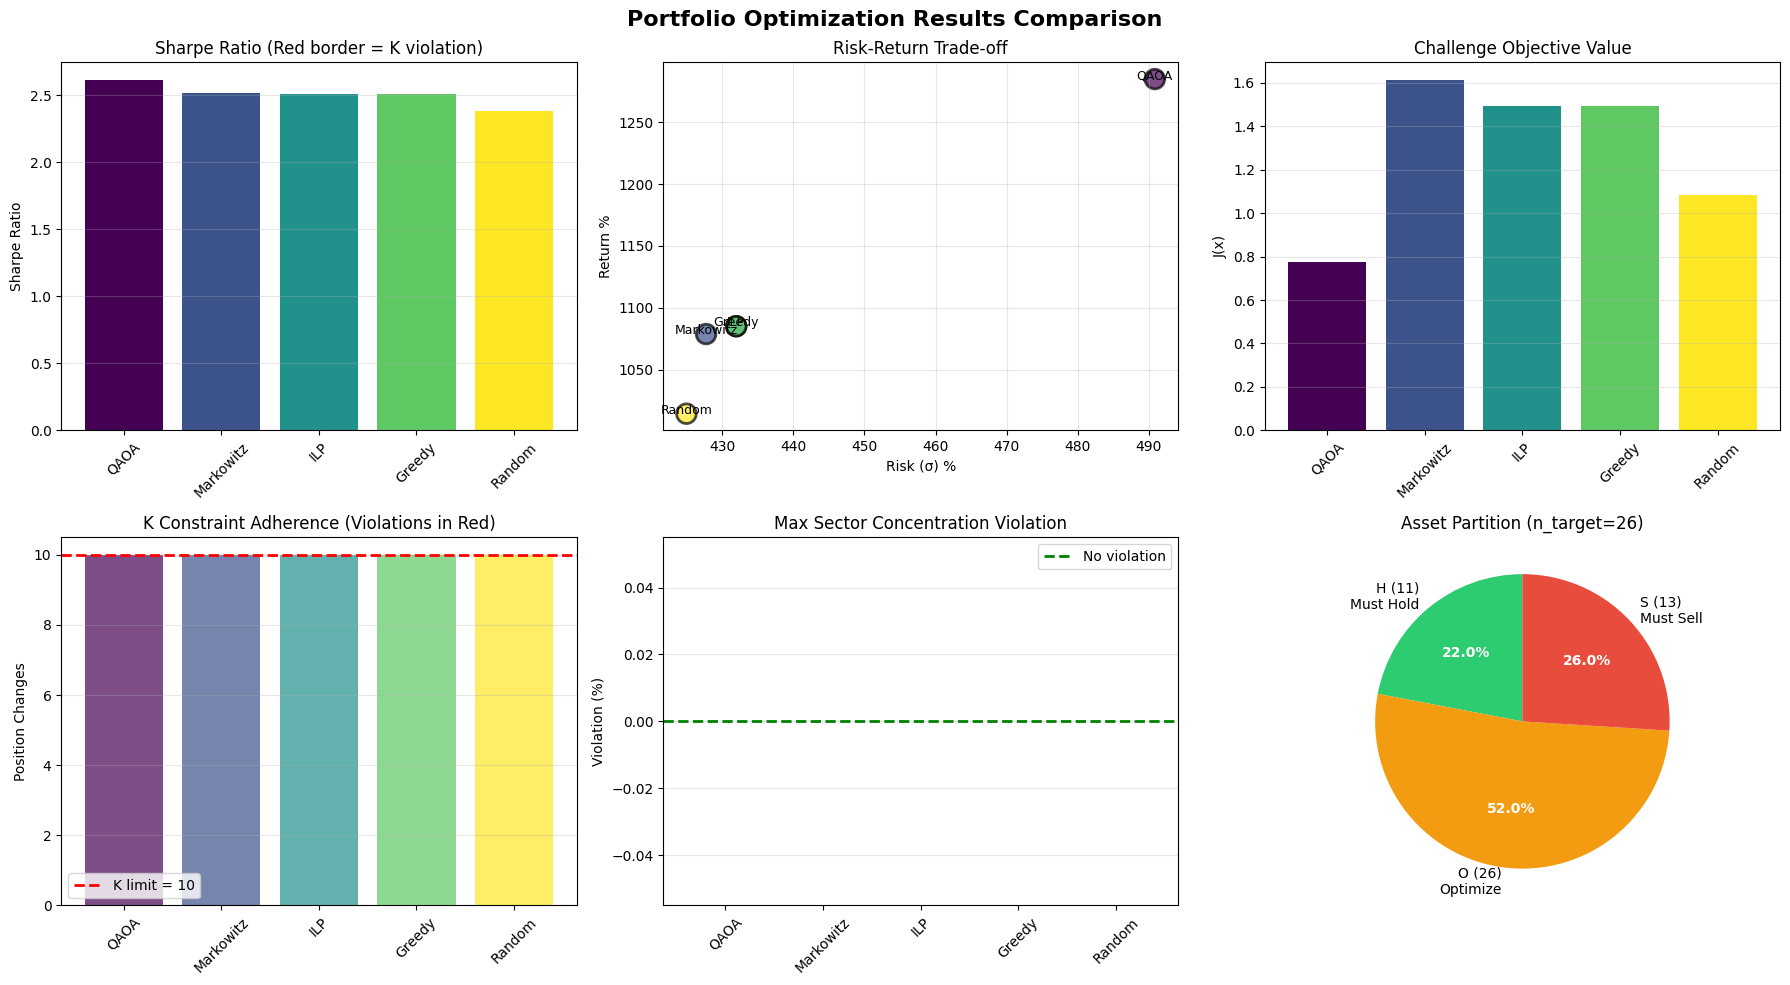

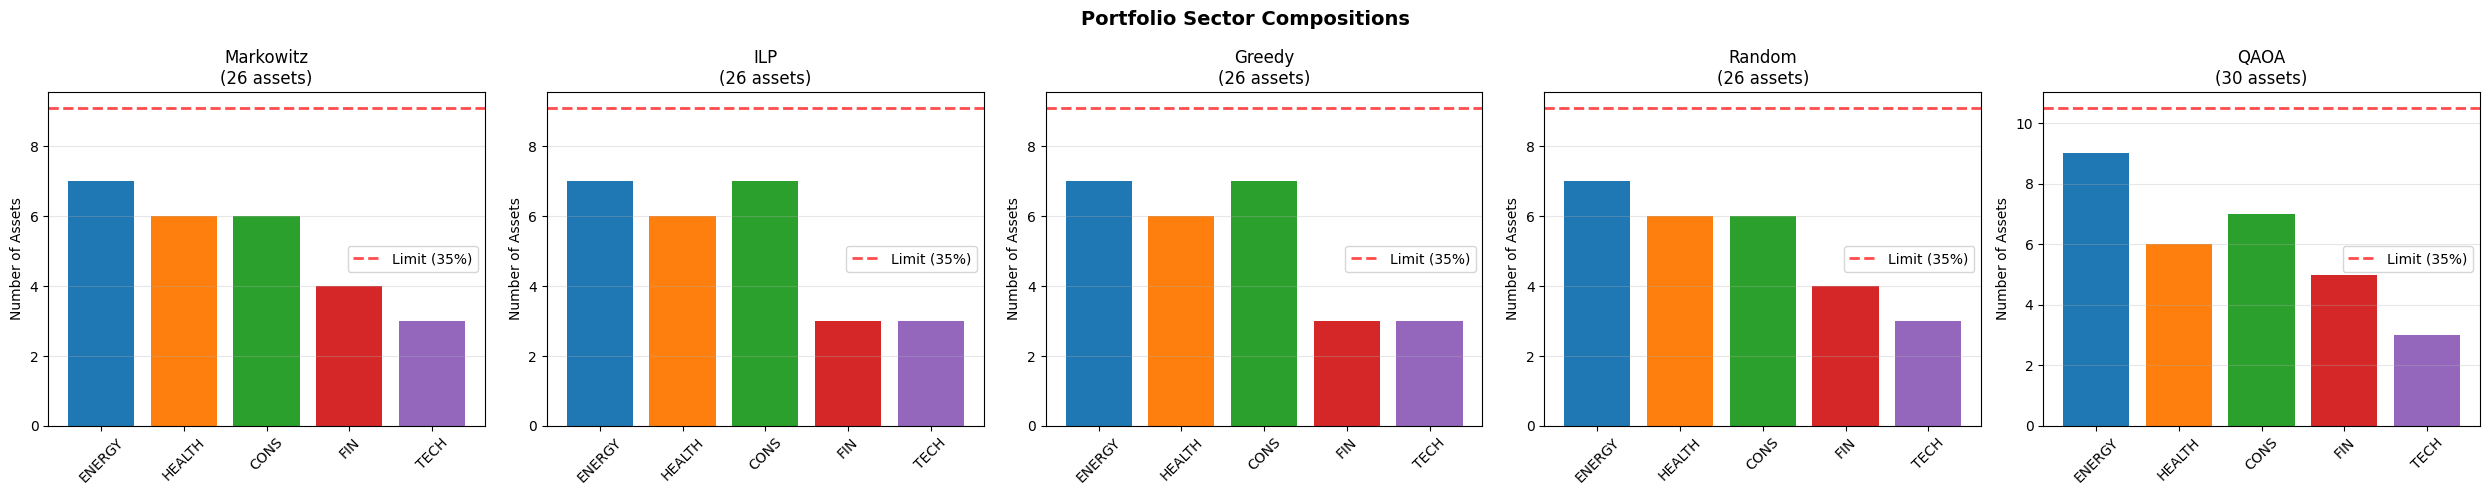


PIPELINE COMPLETE


In [ ]:
if __name__ == "__main__":
    print("\n" + "=" * 80)
    print("INITIALISING PORTFOLIO OPTIMISATION PIPELINE")
    print("=" * 80)

    # Generate synthetic data
    print("\n[Data] Loading portfolio data...")
    data = load_real_portfolio_data("AQC-PAQC-FinanceTrack-Dataset.csv")
    print(f"  ✓ {data.n_assets} assets")
    print(f"  ✓ {len(set(data.sector_map.values()))} sectors")
    print(f"  ✓ Currently holding {np.sum(data.x_prev)} assets")

    # Set parameters
    params = ProblemParameters(
        n_assets=50,
        n_target=25,
        K_max_changes=10,
        lambda_risk=0.5,
        gamma_tc=0.1,
        risk_free_rate=0.02
    )

    print("\n[Parameters]")
    print(f"  • Target portfolio size: {params.n_target}")
    print(f"  • Max position changes (K): {params.K_max_changes}")
    print(f"  • Risk aversion (λ): {params.lambda_risk}")
    print(f"  • Transaction cost weight (γ): {params.gamma_tc}")

    # Run pipeline
    df_results, results, partition = run_portfolio_optimization_pipeline(
        data,
        params,
        run_qaoa=QISKIT_AVAILABLE  # Only run QAOA if Qiskit available
    )

    # Visualize
    print("\n[Visualisation] Generating plots...")
    visualize_results(df_results, results, partition, data)

    print("\n" + "=" * 80)
    print("PIPELINE COMPLETE")
    print("=" * 80)
